# Image Classification
In this project, I'll classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. I'll preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded.  I'll build convolutional, max pooling, dropout, and fully connected layers.  At the end, I'll visualize my neural network's predictions on the sample images.

In [2]:
#Get the Data
#Download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

# Use Floyd's cifar-10 dataset if present
floyd_cifar10_location = 'cifar-10-python.tar.gz'
if isfile(floyd_cifar10_location):
    tar_gz_path = floyd_cifar10_location
else:
    tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

CIFAR-10 Dataset: 171MB [01:10, 2.42MB/s]                               


All files found!


## Explore the Data
The dataset is broken into batches to prevent the machine from running out of memory.  The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 5:
Image - Min Value: 0 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


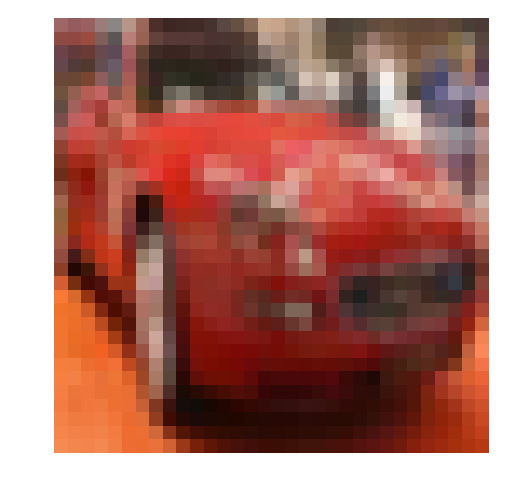

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 5
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalize
In the cell below, I implement the `normalize` function to take in image data, `x`, and return it as a normalized Numpy array. The values should be in the range of 0 to 1, inclusive.  The return object should be the same shape as `x`.

In [4]:
import numpy as np
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    maxvalue = float(np.max(x))
    minvalue = float(np.min(x))   
    
    return (x-minvalue)/(maxvalue-minvalue)

### One-hot encode
I implement the `one_hot_encode` function. The input, `x`, are a list of labels.  Implement the function to return the list of labels as One-Hot encoded Numpy array.  The possible values for labels are 0 to 9. The one-hot encoding function should return the same encoding for each value between each call to `one_hot_encode`.  Make sure to save the map of encodings outside the function.

In [5]:
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    res = np.eye(10)[x]
    return res

## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [6]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Check Point
This is the first checkpoint.  If you ever decide to come back to this notebook or have to restart the notebook, you can start from here.  The preprocessed data has been saved to disk.

In [7]:
import pickle
import helper
import numpy as np

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network
For the neural network, I'll build each layer into a function.

### Inputs

In [8]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    a,b,c = image_shape
    return tf.placeholder(tf.float32,
                         shape = [None,a,b,c],
                         name = 'x')


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    return tf.placeholder(tf.float32,
                         shape=[None,n_classes],
                         name = 'y')


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    return tf.placeholder(tf.float32,
                         name = 'keep_prob')


tf.reset_default_graph()

### Convolution and Max Pooling Layer

In [9]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    
    k1,k2 = conv_ksize
    h = x_tensor.shape[-1]
    shape = np.array([k1,k2,h,conv_num_outputs])
    shape = shape.astype(np.int32)
    # Need to note the spetial request of tf.truncated_normal
    conv_weights = tf.Variable(tf.truncated_normal(shape, dtype=tf.float32, stddev=0.1))
    conv_bias = tf.Variable(tf.zeros([conv_num_outputs], dtype=tf.float32))
    
    s1,s2 = conv_strides
    conv = tf.nn.conv2d(x_tensor, conv_weights, strides=[1,s1,s2,1], padding='SAME')
    conv = tf.nn.bias_add(conv, conv_bias)
    
    ksize = [1,pool_ksize[0],pool_ksize[1],1]
    strides = [1,pool_strides[0],pool_strides[1],1]
    max_pool = tf.nn.max_pool(conv, ksize=ksize, strides=strides, padding='SAME')
    
    res = tf.nn.relu(max_pool)
    return (res)

### Flatten Layer

In [10]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    dim = np.prod(x_tensor.shape[1:])
    shape = np.array([-1,dim])
    return tf.reshape(x_tensor, shape)


### Fully-Connected Layer

In [11]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    i = x_tensor.shape[-1]
    shape = np.array([i,num_outputs])
    shape = shape.astype(np.int32)
    standard_deviation = float(1)/np.sqrt(num_outputs)
    weights = tf.Variable(tf.truncated_normal(shape, dtype=tf.float32, stddev=standard_deviation))
    bias = tf.Variable(tf.truncated_normal([num_outputs], dtype=tf.float32))
    
    logistic = tf.add(tf.matmul(x_tensor, weights), bias)
    
    logistic = tf.nn.relu(logistic)
    return logistic

### Output Layer
**Note:** Activation, softmax, or cross entropy do **not** be applied to this.

In [12]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    i = x_tensor.shape[-1]
    shape = np.array([i,num_outputs])
    shape = shape.astype(np.int32)
    weights = tf.Variable(tf.truncated_normal(shape, dtype=tf.float32))
    bias = tf.Variable(tf.truncated_normal([num_outputs], dtype=tf.float32))
    
    logistic = tf.add(tf.matmul(x_tensor, weights), bias)
    return logistic

### Create Convolutional Model
Implement the function `conv_net` to create a convolutional neural network model. The function takes in a batch of images, `x`, and outputs logits.

In [13]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    
    x = conv2d_maxpool(x, 32, (3,3), (2,2), (2,2), (1,1))
    x = conv2d_maxpool(x, 64, (3,3), (2,2), (2,2), (1,1))
    x = conv2d_maxpool(x, 128, (3,3), (2,2), (2,2), (1,1))
    
    x = flatten(x)
    
    x = fully_conn(x, 256)
    x = fully_conn(x, 128)
    x = fully_conn(x, 64)
    x = tf.nn.dropout(x, keep_prob)

    x = output(x, 10)
    
    return x


# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

## Train the Neural Network

### Single Optimization
Note: Nothing needs to be returned. This function is only optimizing the neural network.

In [14]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    session.run(optimizer,
               feed_dict = {x:feature_batch, y:label_batch, 
                            keep_prob:keep_probability})

### Show Stats

In [15]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    loss = session.run(cost, 
                       feed_dict={x:feature_batch, y:label_batch,
                                 keep_prob:1.0})
    valid_accu = session.run(accuracy,
                      feed_dict={x:valid_features, y:valid_labels,
                                 keep_prob:1.0})
    print ('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss,valid_accu))


### Hyperparameters

In [16]:
# TODO: Tune Parameters
epochs = 20
batch_size = 128
keep_probability = 0.5

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's use a single batch. This should save time while you iterate on the model to get a better accuracy.  Once the final validation accuracy is 50% or greater, run the model on all the data in the next section.

In [17]:
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.1803 Validation Accuracy: 0.142600
Epoch  2, CIFAR-10 Batch 1:  Loss:     2.0918 Validation Accuracy: 0.183000
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.9589 Validation Accuracy: 0.249200
Epoch  4, CIFAR-10 Batch 1:  Loss:     1.9092 Validation Accuracy: 0.295000
Epoch  5, CIFAR-10 Batch 1:  Loss:     1.9289 Validation Accuracy: 0.248400
Epoch  6, CIFAR-10 Batch 1:  Loss:     1.8118 Validation Accuracy: 0.345800
Epoch  7, CIFAR-10 Batch 1:  Loss:     1.7397 Validation Accuracy: 0.377200
Epoch  8, CIFAR-10 Batch 1:  Loss:     1.6303 Validation Accuracy: 0.373200
Epoch  9, CIFAR-10 Batch 1:  Loss:     1.6087 Validation Accuracy: 0.403000
Epoch 10, CIFAR-10 Batch 1:  Loss:     1.4515 Validation Accuracy: 0.399200
Epoch 11, CIFAR-10 Batch 1:  Loss:     1.3922 Validation Accuracy: 0.430800
Epoch 12, CIFAR-10 Batch 1:  Loss:     1.3408 Validation Accuracy: 0.431400
Epoch 13, CIFAR-10 Batch 1:  Loss:     1.2000

### Fully Train the Model
Now that you got a good accuracy with a single CIFAR-10 batch, try it with all five batches.

In [37]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.3326 Validation Accuracy: 0.143800
Epoch  1, CIFAR-10 Batch 2:  Loss:     2.3246 Validation Accuracy: 0.218400
Epoch  1, CIFAR-10 Batch 3:  Loss:     2.1843 Validation Accuracy: 0.233400
Epoch  1, CIFAR-10 Batch 4:  Loss:     2.2749 Validation Accuracy: 0.240600
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.9969 Validation Accuracy: 0.277000
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.8871 Validation Accuracy: 0.311600
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.8815 Validation Accuracy: 0.379800
Epoch  2, CIFAR-10 Batch 3:  Loss:     1.5351 Validation Accuracy: 0.391400
Epoch  2, CIFAR-10 Batch 4:  Loss:     1.6710 Validation Accuracy: 0.420400
Epoch  2, CIFAR-10 Batch 5:  Loss:     1.6176 Validation Accuracy: 0.446400
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.5834 Validation Accuracy: 0.449400
Epoch  3, CIFAR-10 Batch 2:  Loss:     1.5831 Validation Accuracy: 0.461000
Epoch  3, CIFAR-10 Batch 3:  Loss:     1.1179 Validation Accuracy: 0.486000


# Checkpoint
The model has been saved to disk.
## Test Model
Test your model against the test dataset.  This will be your final accuracy. You should have an accuracy greater than 50%. If you don't, keep tweaking the model architecture and parameters.

Testing Accuracy: 0.6509098101265823



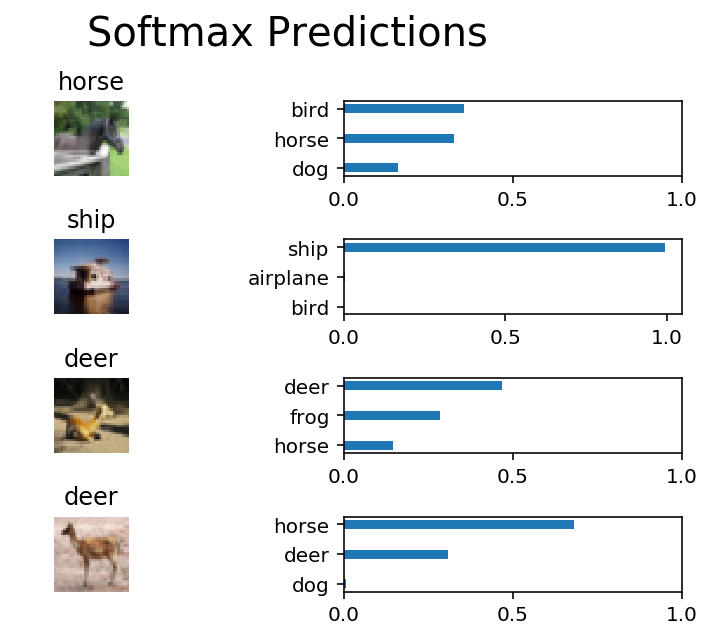

In [39]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()